In [1]:

import numpy as np
from sklearn.linear_model import LinearRegression

def generate_base_predictions(models, dataset):
    base_predictions = {}
    for name, model in models.items():
        print(name)
        print(model)
        # Ensure the dataset is batched appropriately, as model.predict expects batched data
        predictions = model.predict(dataset.batch(32)) 
        base_predictions[name] = predictions
    return base_predictions


def prepare_meta_model_input(base_predictions):
    # Assuming all predictions are numpy arrays; stack them along the last axis
    features = np.hstack([preds for preds in base_predictions.values()])
    return features

def train_meta_model(features, labels):
    meta_model = LinearRegression()
    meta_model.fit(features, labels)
    return meta_model

In [2]:
import os
import re
import numpy as np
import tensorflow as tf


# In case I want to go back to one channel.
# def rgb_to_three_channel_grayscale(image):
#     grayscale_image = tf.image.rgb_to_grayscale(image)
#     return tf.repeat(grayscale_image, repeats=3, axis=-1)

def preprocess_image(rgb_path, target_size=(200, 200)):
    rgb_image = tf.io.read_file(rgb_path)
    rgb_image = tf.image.decode_png(rgb_image, channels=3)
    rgb_image = tf.image.resize(rgb_image, target_size)
    return rgb_image / 255.0

def parse_image_filename(filename, zones):
    match = re.search(r'image\.(\d+)\.rgb\.png', filename)
    if match:
        azimuth = int(match.group(1)) % 360
        return azimuth // (360 // zones)
    return 0

def split_dataset(data, split_ratios=(0.8, 0.1, 0.1)):
    indices = np.random.permutation(len(data))
    split1 = int(split_ratios[0] * len(data))
    split2 = split1 + int(split_ratios[1] * len(data))
    return [data[i] for i in indices[:split1]], [data[i] for i in indices[split1:split2]], [data[i] for i in indices[split2:]]

def create_dataset(image_paths, labels, preprocess_func):
    image_ds = tf.data.Dataset.from_tensor_slices(image_paths).map(preprocess_func, num_parallel_calls=tf.data.AUTOTUNE)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((image_ds, label_ds))

def load_images_from_directory(base_dir, preprocess_func, split_ratios=(0.7, 0.2, 0.1), zones = 4):
    all_image_paths, all_labels = [], []
    for folder_name in sorted(os.listdir(base_dir)):
        folder_path = os.path.join(base_dir, folder_name)
        if os.path.isdir(folder_path):
            for filename in sorted(os.listdir(folder_path)):
                if filename.endswith(".rgb.png"):
                    elevation = int(folder_name)
                    azimuth_zone = parse_image_filename(filename, zones)
                    file_path = os.path.join(folder_path, filename)
                    all_image_paths.append(file_path)
                    all_labels.append([elevation, azimuth_zone]) 
                    

    # Shuffle the dataset
    indices = np.random.permutation(len(all_image_paths))
    all_image_paths = np.array(all_image_paths)[indices]
    all_labels = np.array(all_labels)[indices]

    # Split the dataset
    train_size = int(len(all_image_paths) * split_ratios[0])
    val_size = int(len(all_image_paths) * split_ratios[1])

    train_paths = all_image_paths[:train_size]
    val_paths = all_image_paths[train_size:train_size + val_size]
    test_paths = all_image_paths[train_size + val_size:]

    train_labels = all_labels[:train_size]
    val_labels = all_labels[train_size:train_size + val_size]
    test_labels = all_labels[train_size + val_size:]

    # Create datasets
    train_ds = create_dataset(train_paths, train_labels, preprocess_func)
    val_ds = create_dataset(val_paths, val_labels, preprocess_func)
    test_ds = create_dataset(test_paths, test_labels, preprocess_func)

    return train_ds, val_ds, test_ds

2024-05-01 15:18:06.923674: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 15:18:06.923738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 15:18:07.017279: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 15:18:07.203062: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-01 15:18:08.174762: W tensorflow/compiler/tf2

In [3]:

base_dir = '../data/raw_experimental_data'


train_ds_360, val_ds_360, test_ds_360 = load_images_from_directory(
        base_dir, 
        lambda path: preprocess_image(path, (200, 200)), 
        split_ratios=(0.7, 0.2, 0.1),
        zones = 360,
    )

2024-05-01 15:18:48.034987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 15:18:48.333538: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 15:18:48.333721: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
# train_ds_4, val_ds_4, test_ds_4 = load_images_from_directory(
#         base_dir, 
#         lambda path: preprocess_image(path, (200, 200)), 
#         split_ratios=(0.7, 0.2, 0.1),
#         zones = 4,
#     )

In [4]:
from tensorflow.keras.models import load_model

paths_to_models_360 = {
    'densenet': '../src/models/az_models_densenet/best_model_zones_360.h5',
    'resnet': '../src/models/az_models_resnet/best_model_zones_360.h5',
}
paths_to_models_el = {
    'densenet': '../src/models/el_model_densenet/best_model_elevations_densenet.h5',
    # 'densenet_mse': '../src/models/el_model_densenet/best_model_elevations_densenet_mse.h5',
    'resnet_mse': '../src/models/el_model_resnet/best_model_elevations_resnet101.h5'
}

# Load models (assuming they're already trained)
models_360 = {name: load_model(path) for name, path in paths_to_models_360.items()}
models_el = {name: load_model(path) for name, path in paths_to_models_el.items()}



In [5]:
base_predictions_360 = generate_base_predictions(models_360, train_ds_360)
features_360 = prepare_meta_model_input(base_predictions_360)

# base_predictions_el = generate_base_predictions(models_el, train_ds_360)
# features_el = prepare_meta_model_input(base_predictions_el)


densenet


2024-05-01 15:21:07.841139: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-01 15:21:08.149780: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


   7/2993 [..............................] - ETA: 54s   

2024-05-01 15:21:08.981521: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


2993/2993 [==============================] - 77s 25ms/step
resnet
2993/2993 [==============================] - 61s 20ms/step


In [6]:
validation_labels_360 = np.concatenate([y for _, y in train_ds_360.batch(1024)])

In [7]:

# Train the meta-model (you can choose any model as a meta-model; here we use a simple logistic regression for demonstration)
from sklearn.linear_model import LogisticRegression
def train_meta_model(features, labels):
    meta_model = LogisticRegression()
    meta_model.fit(features, labels)
    return meta_model

meta_model_360 = train_meta_model(features_360, validation_labels_360[:,1])
# meta_model_el = train_meta_model(features_el, validation_labels_360[:,0])

In [15]:
real_image_paths = []

output_folder = '/home/andrey/msds_practicum/msds_practicum/data/film'
# Loop through the directory containing the images
for filename in os.listdir(output_folder):
    if filename.endswith('.png'):  # Check for PNG files
        # Create the full path to the image and add it to the list
        path = os.path.join(output_folder, filename)
        real_image_paths.append(path)

# Now image_paths contains all the paths to the images
print("List of image paths:")
for path in image_paths:
    print(path)

real_elevation_labels = [18,60,60,60,60,
                         60,60,60,55,50,
                         50,50,45,45,45,
                         40,0,0,0,0, #20
                         0,0,0,0,20,
                         65,65,65,65,65,#30
                         65,65,65,65,65,
                         65,70,55,53,53, #40
                         50,10,0,0,0,
                         0,0,0,30,30,#50
                         30,30,0,0,0,
                         0,0,0,0,0, #60
                         0,55,55,55,55,
                         55,55,55,55,55,
                         55,55,55,55,55,
                         65,65,65,65,65, #80
                         65,65,65,65,65,
                         65,65,65,65,65, #90
                         65,65,65,65,65,
                         65,65,65,65,65, #100
                         65,65,65,65,65,
                         65,65,65,65,65, #110
                        65,65,65,65,65,
                        65,55,55,55,55, #120
                        50,55,55,55,50,
                        50,50,50,50,50, #130
                        45,45,45,45,45,
                        40,40,40,40,35,#140
                        33,33,30, 30,30,
                        30, 27, 0,0,0,#150
                        0,0,0,0]

real_azimuth_labels = [90,90,90,90,91,
                       100,110,110,110,110,
                       110,110,110,110,110,
                       110,110,110,110,115,#20
                       150,160,160,160,160,
                       170,170,170,175,185,#30
                       185,185,185,200,200,
                       200,203,215,215,225,#40
                       225,235,230,235,250,
                       260,260,260,260,260,#50
                       260,260,260,260,260,
                       260,260,260,260,260,#60
                       260,260,260,260,260,
                       265,265,265,265,265, #70
                       265,265,265,265,265,
                       265,265,265,265,268,#80
                       280,280,280, 290,295,
                       295,300,305,310,315,#90
                       315,335,350, 350, 355,
                       355, 3,3,3,3,#100
                       20,30, 30, 30, 50,
                       60,60,60,85,85, #110
                       90,90,100,125,125,
                       125,125,125,125,125,#120
                       125,125,125,125,125,
                       125,125,125,125,125,#130
                       125,125,125,125,125,
                       125,125,125,125,125,#140
                       125,125,125,125,125,
                       125,125,125,125,125,#150
                       130,145,145,145]  # Dummy azimuth values

def preprocess_real_images(image_path):
    # This assumes the preprocess function and grayscale conversion are correctly defined
    rgb_image = tf.io.read_file(image_path)
    rgb_image = tf.image.decode_png(rgb_image, channels=3)  # Adjust if images are not PNG
    rgb_image = tf.image.resize(rgb_image, [200, 200])
    rgb_image = rgb_image / 255.0  # Normalize to [0,1]
    return rgb_image  # Assuming this function is defined

def preprocess_image(image_path):
    """Load and preprocess an image."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)  # Assuming images are in PNG format
    image = tf.image.resize(image, [200, 200])  # Resize to the desired size for your model
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image  # Here, keep it in RGB if that's what the model expects

def create_tf_dataset(image_paths, elevation_labels, azimuth_labels):
    """Create a TensorFlow dataset from image paths and labels."""
    image_ds = tf.data.Dataset.from_tensor_slices(image_paths).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices({
        'elevation': tf.cast(elevation_labels, tf.int64),
        'azimuth': tf.cast(azimuth_labels, tf.int64)  // (360)
    })

    # Combine into a single dataset
    dataset = tf.data.Dataset.zip((image_ds, labels_ds))
    return dataset

real_dataset = create_tf_dataset(real_image_paths, real_elevation_labels, real_azimuth_labels)


def create_tf_dataset_images(image_paths ):
    """Create a TensorFlow dataset from image paths and labels."""
    image_ds = tf.data.Dataset.from_tensor_slices(image_paths).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)


    # Combine into a single dataset
    dataset = tf.data.Dataset.zip((image_ds))
    return dataset

real_dataset_images = create_tf_dataset_images(real_image_paths).batch(32)




List of image paths:
/home/andrey/msds_practicum/msds_practicum/data/film/frame_0048.png
/home/andrey/msds_practicum/msds_practicum/data/film/frame_0131.png
/home/andrey/msds_practicum/msds_practicum/data/film/frame_0081.png
/home/andrey/msds_practicum/msds_practicum/data/film/frame_0091.png
/home/andrey/msds_practicum/msds_practicum/data/film/frame_0094.png
/home/andrey/msds_practicum/msds_practicum/data/film/frame_0093.png
/home/andrey/msds_practicum/msds_practicum/data/film/frame_0123.png
/home/andrey/msds_practicum/msds_practicum/data/film/frame_0018.png
/home/andrey/msds_practicum/msds_practicum/data/film/frame_0032.png
/home/andrey/msds_practicum/msds_practicum/data/film/frame_0088.png
/home/andrey/msds_practicum/msds_practicum/data/film/frame_0022.png
/home/andrey/msds_practicum/msds_practicum/data/film/frame_0134.png
/home/andrey/msds_practicum/msds_practicum/data/film/frame_0075.png
/home/andrey/msds_practicum/msds_practicum/data/film/frame_0125.png
/home/andrey/msds_practicum

In [16]:
def generate_features_from_base_models(models, dataset):
    all_features = []
    all_images = []  # Store images for visualization

    # Iterate through each batch in the dataset
    for images in dataset:  # Assuming dataset yields images only or (images, labels) pairs
        batch_features = []
        for model in models.values():
            # Predict with each base model and collect predictions
            predictions = model.predict(images)
            batch_features.append(predictions)
        # Stack predictions horizontally to form feature vectors for each image in batch
        features = np.hstack(batch_features)
        all_features.append(features)
        all_images.extend(images.numpy())  # Storing images for later visualization

    # Concatenate all batches to form a complete feature set
    final_features = np.vstack(all_features)
    return final_features, all_images

In [17]:
final_features_360, images_for_visualization = generate_features_from_base_models(models_360, real_dataset_images)
# final_features_el, images_for_visualization = generate_features_from_base_models(models_el, real_dataset_images)


1/1 [==============================] - 1s 920ms/step


In [18]:
final_predictions_360 = meta_model_360.predict(final_features_360)


In [19]:
from tensorflow.keras.models import load_model

elevation_model = load_model('../src/models/el_model_resnet/best_model_elevations_resnet101.h5')

In [20]:
outputs = elevation_model.predict(real_dataset_images)
elevation_predict = outputs[:,] 

5/5 [==============================] - 1s 28ms/step


In [21]:
elevation_predict

array([[14.993695 ],
       [49.90914  ],
       [51.72379  ],
       [58.90016  ],
       [58.067085 ],
       [59.525627 ],
       [49.864952 ],
       [ 8.388658 ],
       [50.033554 ],
       [51.25088  ],
       [43.482727 ],
       [49.90659  ],
       [55.900288 ],
       [49.941612 ],
       [69.82999  ],
       [46.22805  ],
       [50.192085 ],
       [50.122868 ],
       [49.80027  ],
       [55.00588  ],
       [70.03569  ],
       [43.134605 ],
       [60.646126 ],
       [31.996525 ],
       [ 9.951488 ],
       [15.003271 ],
       [49.841297 ],
       [60.104637 ],
       [70.012405 ],
       [59.724693 ],
       [49.724224 ],
       [60.20243  ],
       [65.44862  ],
       [61.909813 ],
       [49.92539  ],
       [65.091156 ],
       [51.015194 ],
       [70.07237  ],
       [48.868748 ],
       [70.09179  ],
       [ 9.935587 ],
       [49.929977 ],
       [ 7.393849 ],
       [30.104519 ],
       [50.703255 ],
       [51.862877 ],
       [49.82835  ],
       [14.99

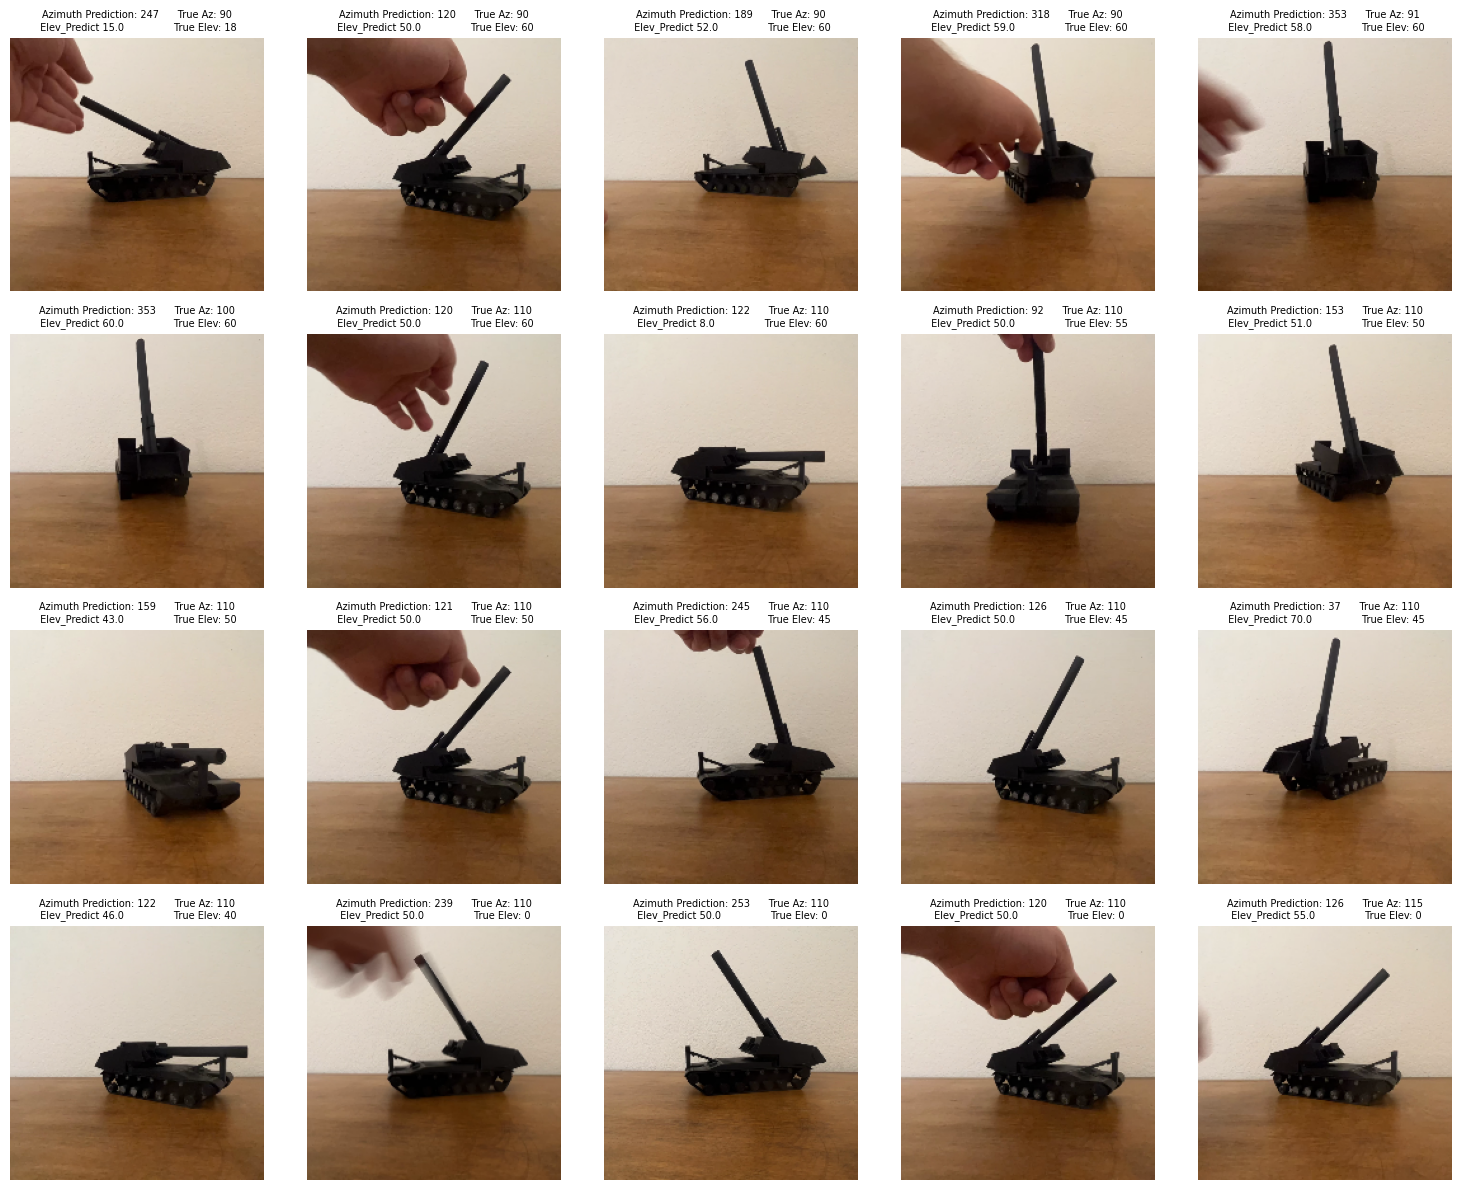

In [23]:
import matplotlib.pyplot as plt

def visualize_predictions(images, predictions_high, labels, el_labels, elev, rows=4, cols=5):
    """
    Visualizes images with predictions in a grid layout.

    Args:
    images (list or array): List of images to display.
    predictions (list): List of predicted labels for the images.
    labels (list): List of true labels for comparison.
    rows (int): Number of rows in the grid.
    cols (int): Number of columns in the grid.

    Note:
    Ensure that rows * cols is >= len(images), otherwise not all images will be displayed.
    """
    plt.figure(figsize=(3 * cols, 3 * rows))  # Adjust the size as needed
    for i in range(min(len(images), rows * cols)):  # Limit to grid size
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap='gray')  # Adjust color mapping if needed
        plt.title(f'Azimuth Prediction: {predictions_high[i]}      True Az: {labels[i]}\n Elev_Predict {elevation_predict[i][0].round()}                True Elev: {el_labels[i]}', fontsize=7)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
# Visualize the first few predictions
visualize_predictions(images_for_visualization, final_predictions_360, real_azimuth_labels, real_elevation_labels, outputs, rows=4, cols=5)

